# Will a Customer Accept the Coupon?

## Import Python Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# filter future warnings
import warnings
warnings.filterwarnings('ignore', category= FutureWarning)

In [2]:
## Custom color map
from  matplotlib.colors import LinearSegmentedColormap
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
custom_cmap =LinearSegmentedColormap.from_list('rg',l, N=256)

## Read and Clean Data

In [3]:
# read and visualize data
data = pd.read_csv('data/coupons.csv')
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

### Missing Data

Using the code snippet below, we can see that the column _'car'_ is missing 99% of the values. This is a data field which we may not be able to use in the analysis.

However, there are other columns like _'Bar'_, _'CoffeeHouse'_, etc. which have a count of the average no. of times a customer went to an establishment like that. These columns have 1-2% of the data missing. We have two options here:

1. Ignore rows with NaNs, and remove them from our analysis.
2. Replace NaNs with _'never'_ based on the assumption that if data is missing, the customer never goes to that category of food store.

We are going to choose option 1 for now.

In [5]:
# What fraction of values are Null/NaN?

na_fraction = np.round(data.isna().sum()/data.shape[0],2)
print(na_fraction[na_fraction > 0]) # print columns with null values

# drop rows with NaNs in rows other than column 'car'
data.dropna(subset= na_fraction[(na_fraction >0) & (na_fraction < 0.99)].index.tolist(), inplace= True)

car                     0.99
Bar                     0.01
CoffeeHouse             0.02
CarryAway               0.01
RestaurantLessThan20    0.01
Restaurant20To50        0.01
dtype: float64


### Sanity Checks (after dropping NaN)

After removing NaNs, *~57%* of the population chose to accept the coupon.

There are two columns for direction: check that both cannot be zero or one.


In [6]:
# chose to accept coupon
print( np.round(data['Y'].sum()/data.shape[0],2))

# bar plot of coupon
# data['coupon'].value_counts().sort_values(ascending= False).plot(kind= 'bar', title= "Count of Different Types of Coupons");

# histogram of temperature column
# data['temperature'].plot(kind= 'hist', title= "Histogram of Temperature");

0.57


In [7]:
data[['direction_same','direction_opp']].sum(axis= 1).value_counts() # all rows sum up to 1

1    12079
Name: count, dtype: int64

### Cleaning Data

#### 1.'Coupon' column
The values in coupon column and the different columns for the type of shop frequented are the same. But there are slight differences in spelling etc. We hypothesize that the chances of accepting a Bar coupon are higher if a customer goes to a bar frequently. Therefore, I try to make these two values the same.

#### 2. New column with replaced values of 'Y'
For ease in plotting, create a new column _'Accepted'_ which has values of 'Yes' and 'No', instead of 0 and 1.

#### 3. New column for direction
Combine _direction_same_ and _direction_opp_ into a single column called _Direction_. This column also has a 'N/A' when there is no specific destination. Currently, the data tags all 'No Urgent Place' destinations as 'Opposite', which might misrepresent data.

#### 4. New column for age
The _age_ column currently is a string object column. In order to make it numeric, we will replace it with ages which represent the mid-point of the age bracket. This means that 'below21' becomes 10.5, 21 becomes 23, and '50plus' becomes 75 assuming upper age to be 100.

#### 5. Codes for number of visits
The no. of visits columns have values such as _'never'_, _'less1'_, and _'gt8'_. These are easy to interpret as text but even though there is a clear order here, we cannot sort string values. Therefore, we create a code dictionary for these codes.

| Avg. Visit | Description | Code |
| :- |:- |  :-: |
never | Never visits | 0 |
| less1 | N<1 | 1 |
| 1~3 | 1<=N<=3 | 2 |
| 4~8 | 4<=N<=8 | 3 |
| gt8 | 8<N | 4 |43


In [20]:
coupon_dict = {'Carry out & Take away': 'CarryAway', 'Coffee House': 'CoffeeHouse', 'Restaurant(20-50)': 'Restaurant20To50',
               'Restaurant(<20)': 'RestaurantLessThan20'}
data['coupon'] = data['coupon'].replace(coupon_dict)

data['Accepted'] = data['Y'].replace({1:'Yes', 0:'No'})
data['Direction'] = data['direction_same'].replace({0: 'Opposite', 1: 'Same'})
data.loc[data['destination'] == "No Urgent Place", "Direction"] = "N/A"

data['age_new'] = data['age'].replace({'below21': 10.5, '21': 23, '26': 28, '31': 33, '36': 38, '41': 43, '46': 48, '50plus': 75})
order_age = ['below21','21','26','31','36','41','46','50plus']

visit_dict = {'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4}
order_visit = ['never', 'less1', '1~3', '4~8', 'gt8']

## Analyze Data

#### Does destination and/or direction of travel impact coupon acceptance?
Across all different coupon types, we can see that coupon venue being in the same direction as the venue, does not significantly increase the chance of coupon acceptance.

In fact, for _CarryAway_ coupon type, venue being in the opposite direction marginally increases the chances of acceptance. This result is clearly counterintuitive. In order to explore this further, we look into the _destination_, and whether it is in the same direction as the coupon venue.

<ins>**Conclusion:** We can clearly see that when there is no specific destination, the rate of acceptance is higher. However, if the customer is going home, coupon venue being in the same direction as home significantly increases the chances of acceptance.</ins>

In [9]:
pd.pivot_table(data, index= "Direction", columns= "coupon", values= "Y", aggfunc= lambda x: 
               np.round(x.sum()/x.shape[0],2), margins= True)

coupon,Bar,CarryAway,CoffeeHouse,Restaurant20To50,RestaurantLessThan20,All
Direction,,,,,,
N/A,0.41,0.76,0.58,0.50,0.79,0.63
Opposite,0.38,0.74,0.32,0.41,0.52,0.45
Same,0.46,0.71,0.53,0.47,0.63,0.58
All,0.41,0.74,0.50,0.45,0.71,0.57


In [121]:
pd.pivot_table(data, index= "Direction", columns= "destination", values= "Y", aggfunc= lambda x: 
               np.round(x.sum()/x.shape[0],2), margins= True)

destination,Home,No Urgent Place,Work,All
Direction,,,,
N/A,NaN,0.63,NaN,0.63
Opposite,0.43,NaN,0.47,0.45
Same,0.60,NaN,0.56,0.58
All,0.51,0.63,0.50,0.57


In [163]:
tmp_sankey = pd.pivot_table(data, index= ["Direction", "Accepted"], columns= "destination", values= "Y", aggfunc= 'count')

while isinstance(tmp_sankey, pd.DataFrame):
    tmp_sankey = tmp_sankey.unstack()
tmp_sankey.name = 'value'
tmp_sankey = tmp_sankey.dropna().to_frame()

tmp_sankey = tmp_sankey.reorder_levels(["destination","Direction", "Accepted"])

ll = 0 
labels = tmp_sankey.index.levels[ll].tolist()
labels_display = labels.copy()

tmp_sankey.query("destination == 'Home'")



value
destination Direction Accepted       
Home        Opposite  No        932.0
            Same      No        585.0
            Opposite  Yes       698.0
            Same      Yes       870.0

['N/A', 'Opposite', 'Same', 'N/ANo', 'N/AYes', 'OppositeNo', 'OppositeYes', 'SameNo', 'SameYes']
['N/A', 'Opposite', 'Same', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes']
[0, 0, 1, 1, 2, 2]
[3, 4, 5, 6, 7, 8]
[2185, 3785, 1933, 1577, 1084, 1515]


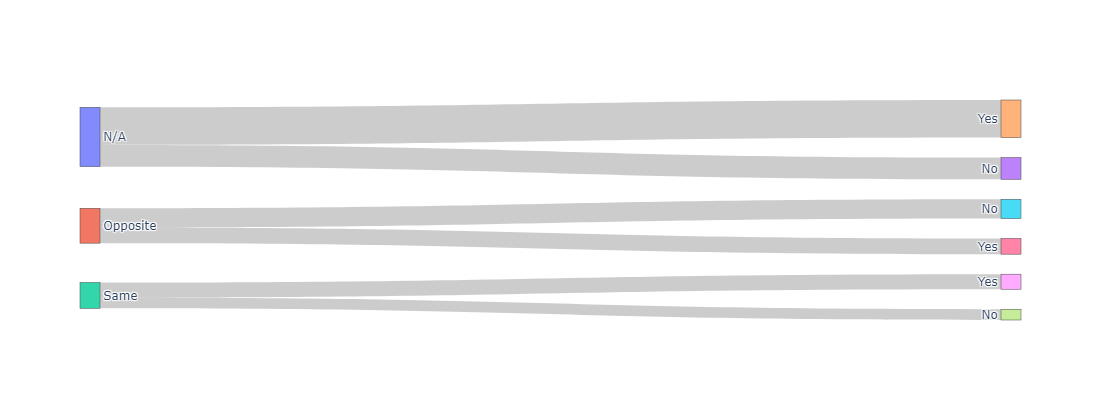

In [152]:
tmp_sankey =  pd.pivot_table(data, index= "Accepted", columns= "Direction", values= "Y", aggfunc= 'count').unstack().dropna()
tmp_sankey.name = 'pct'


labels = tmp_sankey.index.levels[0].tolist()
labels_display = labels.copy()

N = len(labels)

for ii in range(0, N):
    new_labels = tmp_sankey[labels[ii]].index.tolist()
    
    for nn in new_labels:
        labels.append(labels[ii] + nn)
        labels_display.append(nn)

print(labels)
print(labels_display)

names = tmp_sankey.index.names.copy()

tmp_sankey = tmp_sankey.reset_index()

source = [labels.index(kk) for kk in tmp_sankey[names[0]] ]
print(source)

target = [labels.index(kk) for kk in tmp_sankey[names[0:2]].sum(axis= 1)]
print(target)

value = tmp_sankey.pct.tolist()
print(value)


fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": labels_display},  # 10 Pixels
    link = {
        "source": source,
        "target": target,
        "value": value }))

fig.update_layout(height= 400, width= 500)
fig.show()

# tmp_sankey['source'] = tmp_sankey['destination'].apply(lambda x: labels.index(x))

# tmp_sankey['combined'] = tmp_sankey['destination'] + tmp_sankey['Direction']
# labels.extend(tmp_sankey['combined'].unique().tolist() )
# tmp_sankey['target'] = tmp_sankey['combined'].apply(lambda x: labels.index(x))

# tmp_sankey



#### Age and coupon type

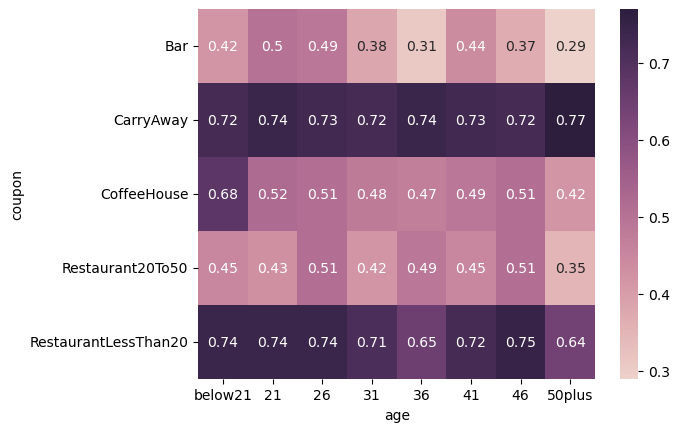

In [11]:
sns.heatmap(pd.pivot_table(data, index= "coupon", columns= "age", values= "Y", aggfunc= lambda x: 
               np.round(x.sum()/x.shape[0],2))[['below21','21','26','31','36','41','46','50plus']], 
            annot= True, cmap= sns.cubehelix_palette(as_cmap=True));

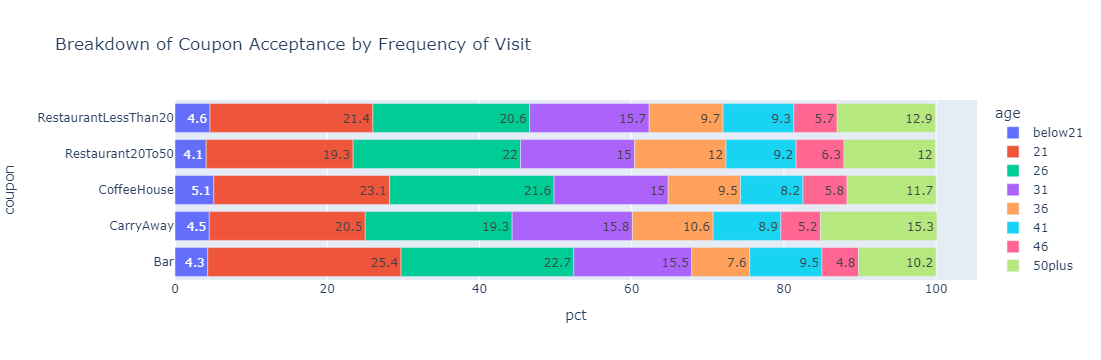

In [14]:
freq_df = pd.pivot_table(data.query("Accepted == 'Yes'"), index= 'age', columns= "coupon", values= "destination", aggfunc= 'count')
freq_df = freq_df.reindex(["below21", "21","26","31","36","41","46","50plus"])
freq_df = freq_df.divide(freq_df.sum()).round(3).unstack()* 100 # convert to percentage
freq_df.name= 'pct'
px.bar(data_frame= freq_df.reset_index(), x = "pct", y= "coupon", color= 'age', text_auto= True, 
       title= "Breakdown of Coupon Acceptance by Frequency of Visit")

### Analyze Coupons of Specific Type

Pct. of coupons accepted for Bar: 41.2%.


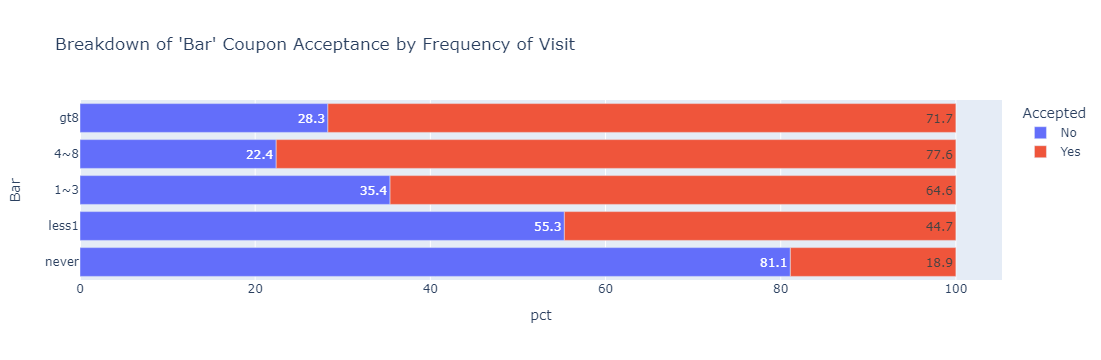

In [18]:
# Extract data for a specific type of coupon
cc = 'Bar'
tmp_dt = data.query(f'coupon == "{cc}"')

# print total rate of acceptance
print("Pct. of coupons accepted for "+ cc + ": " + str(np.round(100*tmp_dt['Y'].agg(lambda x: x.sum()/x.shape[0]),1)) + "%.")

# acceptance rate based on frequency of visit
freq_df = pd.pivot_table(tmp_dt, index= 'Accepted', columns= cc, values= "destination", aggfunc= 'count')[order_visit]
freq_df = freq_df.divide(freq_df.sum()).round(3).unstack()* 100 # convert to percentage
freq_df.name= 'pct'
fig = px.bar(data_frame= freq_df.reset_index(), x = "pct", y= cc, color= 'Accepted', text_auto= True, 
       title= "Breakdown of '" + cc + "' Coupon Acceptance by Frequency of Visit")
fig.show()

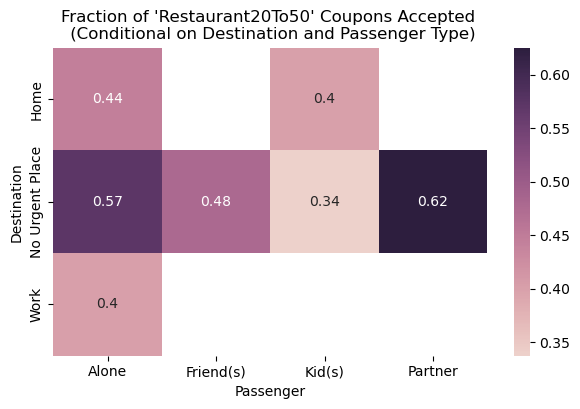

In [17]:
# acceptance rate based on direction and passenger type
plt.figure(figsize = (7,4))
sns.heatmap(pd.pivot_table(tmp_dt, index= "destination", columns= "passanger", values= "Y", aggfunc= lambda x: x.sum()/x.shape[0]),
            annot= True, cmap= sns.cubehelix_palette(as_cmap=True));
plt.title("Fraction of '" + cc+ "' Coupons Accepted \n (Conditional on Destination and Passenger Type)");
plt.xlabel("Passenger");
plt.ylabel("Destination");